In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv'
!wget $data

--2021-10-18 08:19:36--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7077973 (6.8M) [text/plain]
Saving to: ‘AB_NYC_2019.csv’

AB_NYC_2019.csv     100%[===================>]   6.75M  --.-KB/s    in 0.08s   

2021-10-18 08:19:36 (79.9 MB/s) - ‘AB_NYC_2019.csv’ saved [7077973/7077973]



In [3]:
cols = [
    'neighbourhood_group', 'room_type', 'latitude', 'longitude',
    'minimum_nights', 'number_of_reviews','reviews_per_month',
    'calculated_host_listings_count', 'availability_365',
    'price'
]

In [4]:
df = pd.read_csv('AB_NYC_2019.csv', usecols=cols)
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)

In [5]:
df.head(2)

,neighbourhood_group,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355


## Split data into train/val/test

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
full_train, X_test = train_test_split(df, test_size=0.2, random_state=1)
X_train, X_val = train_test_split(full_train, test_size=0.25, random_state=1)

In [8]:
X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

In [9]:
y_train = np.log1p(X_train.price.values)
y_val = np.log1p(X_val.price.values)
y_test = np.log1p(X_test.price.values)

In [10]:
del X_train['price']
del X_val['price']
del X_test['price']

In [14]:
train_dicts = X_train.fillna(0).to_dict(orient='records')
val_dicts = X_val.fillna(0).to_dict(orient='records')
dv = DictVectorizer(sparse=False)

In [15]:
train = dv.fit_transform(train_dicts)
val = dv.transform(val_dicts)

## Question 1

In [16]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score

In [17]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(train, y_train)

DecisionTreeRegressor(max_depth=1)

In [18]:
prediction = dt.predict(val)
prediction

array([4.29239363, 5.14878079, 5.14878079, ..., 5.14878079, 5.14878079,
       5.14878079])

Which feature is used for splitting the data?

In [20]:
from sklearn.tree import export_text
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- room_type=Entire home/apt <= 0.50
|   |--- value: [4.29]
|--- room_type=Entire home/apt >  0.50
|   |--- value: [5.15]



## Question 2

In [21]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=10, random_state=1)
rf.fit(train, y_train)

RandomForestRegressor(n_estimators=10, random_state=1)

In [22]:
prediction = rf.predict(val)
prediction

array([4.8782275 , 4.79199459, 5.49902928, ..., 5.03652684, 4.72644125,
       5.41201993])

What's the RMSE of this model on validation?

In [25]:
def rmse(y_pred, y):
    squared_error = (y_pred - y) ** 2
    mse = squared_error.mean()
    rmse_score = np.sqrt(mse)
    return rmse_score

In [26]:
rmse_score = rmse(prediction, y_val)
rmse_score

0.4598535778342608

## Question 3

In [32]:
scores=[]
for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(train, y_train)

    y_pred = rf.predict(val)
    rmse_score =  rmse(y_pred, y_val)
    scores.append((n,rmse_score))
    
    print(f"# estimators : {n} , RMSE :{rmse_score:.3f}")

# estimators : 10 , RMSE :0.460
# estimators : 20 , RMSE :0.448
# estimators : 30 , RMSE :0.445
# estimators : 40 , RMSE :0.443
# estimators : 50 , RMSE :0.442
# estimators : 60 , RMSE :0.442
# estimators : 70 , RMSE :0.441
# estimators : 80 , RMSE :0.441
# estimators : 90 , RMSE :0.440
# estimators : 100 , RMSE :0.440
# estimators : 110 , RMSE :0.439
# estimators : 120 , RMSE :0.439
# estimators : 130 , RMSE :0.439
# estimators : 140 , RMSE :0.439
# estimators : 150 , RMSE :0.439
# estimators : 160 , RMSE :0.439
# estimators : 170 , RMSE :0.439
# estimators : 180 , RMSE :0.439
# estimators : 190 , RMSE :0.439
# estimators : 200 , RMSE :0.439


After which value of n_estimators does RMSE stop improving?

In [33]:
120

120

## Question 4

In [35]:
scores2 = []
for d in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n, max_depth=d, random_state=1, n_jobs=-1)
        rf.fit(train, y_train)

        y_pred = rf.predict(val)
        rmse_score =  rmse(y_pred, y_val)
        scores2.append((n, rmse_score))

        print(f"# estimators : {n}, depth : {d} , RMSE :{rmse_score:.3f}")

# estimators : 10, depth : 10 , RMSE :0.446
# estimators : 20, depth : 10 , RMSE :0.442
# estimators : 30, depth : 10 , RMSE :0.441
# estimators : 40, depth : 10 , RMSE :0.442
# estimators : 50, depth : 10 , RMSE :0.441
# estimators : 60, depth : 10 , RMSE :0.441
# estimators : 70, depth : 10 , RMSE :0.441
# estimators : 80, depth : 10 , RMSE :0.441
# estimators : 90, depth : 10 , RMSE :0.440
# estimators : 100, depth : 10 , RMSE :0.440
# estimators : 110, depth : 10 , RMSE :0.440
# estimators : 120, depth : 10 , RMSE :0.440
# estimators : 130, depth : 10 , RMSE :0.440
# estimators : 140, depth : 10 , RMSE :0.440
# estimators : 150, depth : 10 , RMSE :0.440
# estimators : 160, depth : 10 , RMSE :0.440
# estimators : 170, depth : 10 , RMSE :0.440
# estimators : 180, depth : 10 , RMSE :0.440
# estimators : 190, depth : 10 , RMSE :0.440
# estimators : 200, depth : 10 , RMSE :0.440
# estimators : 10, depth : 15 , RMSE :0.450
# estimators : 20, depth : 15 , RMSE :0.441
# estimators : 30, de

## Bonus question (not graded):

Will the answer be different if we change the seed for the model?

Yes, the answer might changed if we have small dataset. It might not changed if we have very big dataset.

## Question 5

In [36]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1)
rf.fit(train, y_train)
prediction = rf.predict(val)

What's the most important feature?

In [37]:
f_imp = rf.feature_importances_.round(3)
f_names = dv.get_feature_names()

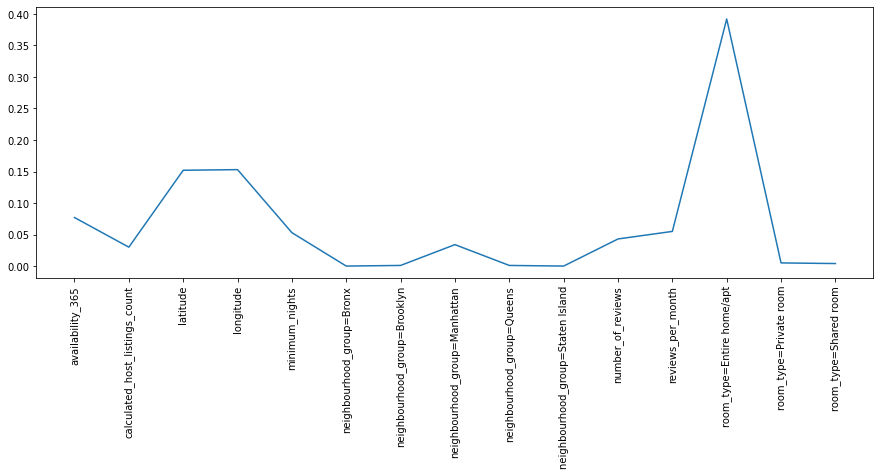

In [46]:
plt.figure(figsize=(15, 5))
plt.plot(f_names, f_imp)
plt.xticks(rotation=90)
plt.show()

## Question 6

In [47]:
!pip install xgboost -q

In [48]:
import xgboost as xgb

In [49]:
features = dv.get_feature_names()

train2 = xgb.DMatrix(train, label=y_train, feature_names=features)
val2 = xgb.DMatrix(val, label=y_val, feature_names=features)

In [53]:
def parse_xgb_output(output):
    results = []
    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])
        results.append((it, train, val))
    columns = ['num_iter', 'train_rmse', 'val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    
    return df_results

In [54]:
watchlist = [(train2, 'train'), (val2, 'val')]

In [61]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

In [65]:
%%capture output
model = xgb.train(xgb_params, train2, num_boost_round=100, evals=watchlist)

In [79]:
df_eta_03 = parse_xgb_output(output)
df_eta_03.tail(50)

,num_iter,train_rmse,val_rmse
50,50,0.39446,0.43384
51,51,0.39388,0.43396
52,52,0.39349,0.43403
53,53,0.39299,0.43407
54,54,0.39205,0.43396
55,55,0.39129,0.43378
56,56,0.39081,0.43389
57,57,0.38988,0.43409
58,58,0.38864,0.43395
59,59,0.38771,0.43399


In [71]:
%%capture output2
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, train2, num_boost_round=100, evals=watchlist)

In [77]:
df_eta_01 = parse_xgb_output(output2)
df_eta_01.head(50)

,num_iter,train_rmse,val_rmse
0,0,3.87217,3.86889
1,1,3.49150,3.48840
2,2,3.14949,3.14635
3,3,2.84232,2.83951
4,4,2.56650,2.56412
5,5,2.31905,2.31692
6,6,2.09714,2.09526
7,7,1.89834,1.89663
8,8,1.72033,1.71878
9,9,1.56120,1.55976


In [73]:
%%capture output3
xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, train2, num_boost_round=100, evals=watchlist)

In [76]:
df_eta_001 = parse_xgb_output(output3)
df_eta_001.head(50)

,num_iter,train_rmse,val_rmse
0,0,4.25336,4.25010
1,1,4.21141,4.20815
2,2,4.16988,4.16661
3,3,4.12877,4.12551
4,4,4.08807,4.08481
5,5,4.04779,4.04454
6,6,4.00792,4.00467
7,7,3.96845,3.96521
8,8,3.92937,3.92615
9,9,3.89070,3.88749
